# Litter Model

Adapted from [LearnableLoopAI](https://learnableloop.com/posts/LitterModel_PORT.html)

In [27]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer/examples`


In [28]:
using RxInfer, Random, Distributions, Plots, LaTeXStrings, XLSX, DataFrames

In this project the client is responsible for the delittering of a mile-long beach walk-way in the Pacific Northwest in the USA. The density of foot traffic is roughly uniform along its length. Volunteers provide their services for cleaning up litter.

## Symbols | Nomenclature |Notation (KUF)
informed by Powell Universal Framework (PUF), Bert de Vries, AIF literature

# Taxonomy of Machine Learning

## Supervised Learning
### State Functions
- **Provision (Acquisition)**
    - $\mathbf{p}_{i} = f_p(i)$

### Observation Functions
- **Response**: $\mathbf{r}_{i} = f_{r}(\breve{\mathbf{s}}_{i})$
- **Observation with Noise**: $\mathbf{y}_i = \mathbf{\breve{s}}_t + \mathbf{v}_t$
    - Covariate noise (optional)
    - Observation noise: $\mathbf{v}_{i} = \mathcal{N}(\mathbf{\breve{m}}_{i}, \mathbf{\breve{\Sigma}_V})$

### Observation Sets
- Without state noise: $(\mathbf{\breve{s}}, y)$
- With state noise: $(\mathbf{z}, y)$

## Unsupervised Learning
### State Functions
- **Provision (Acquisition)**
    - $\mathbf{p}_{i} = f_p(i)$

### Observation Functions
- **Response**: $\mathbf{r}_{i} = f_{r}(\breve{\mathbf{s}}_{i})$
- **Direct Observation**: $\mathbf{y}_t = \mathbf{\breve{s}}_t$

### Observation Sets
- Unordered independent observations: $y$

## Sequential/Series Learning
### State Functions
- **Provision (Transition)**
    - Base transition: $\mathbf{p}_{t} = f_p(\breve{\mathbf{s}}_{t-1})$
    - Complete state equation:
        $\mathbf{\breve{s}}_t = f_B(\mathbf{\breve{s}}_{t-1})+ f_E(\mathbf{a}_t) + \mathbf{w}_{dt} + \mathbf{w}_t$
    - Components:
        - Action: $f_E(\mathbf{a}_t)$ (optional)
        - System noise: $\mathbf{w}_{t} = \mathcal{N}(\mathbf{p}_{t}, \mathbf{\breve{\Sigma}_W})$
        - Disturbance/exogenous: $\mathbf{w}_{dt}$ (optional)

### Observation Functions
- **Response**: $\mathbf{r}_{t} = f_r(\breve{\mathbf{s}}_{t}) = f_A(\breve{\mathbf{s}}_{t}) = \breve{\mathbf{A}} \breve{\mathbf{s}}_{t}$
- **Observation with Noise**: $\mathbf{y}_t = f_A(\mathbf{\breve{s}}_t) + \mathbf{v}_t$
    - Observation noise: $\mathbf{v}_{t} = \mathcal{N}(\mathbf{r}_{t}, \mathbf{\breve{\Sigma}_V})$

### Observation Sequence
- Ordered correlated observations $y$ (time/spatial)

### Overall Structure
- Experiment has one-to-many Batches
	- Batch (into the page) has one-to-many Sequences
		- Sequence (down the page) has one-to-many Datapoints
			- Datapoint (into the page) has one-to-many Matrices
				- Matrix (down the page) has one-to-many Vectors
					- Vector (towards right) has one-to-many Components
						- Component/Element of type
							- Numerical [continuous/proportional]
								- int/real/float (continuous)
							- Categorical [non-continuous/non-formal]
								- AIF calls it 'discrete'
								- ordinal (ordered)
								- nominal (no order)
							- for computers, elements need to be numbers, so categoricals encoded as numbers too
- Most complex Datapoint handled is a multispectral image, i.e. 3D

### True vs Inferred variables:
- True variables associated with Generative Process `genpr`
    - e.g. $\breve{s}, \breve{\mathbf{s}}, \breve{\theta}$
- Inferred variables associated with Generative Model `agent`
    - e.g. $s, \mathbf{s}, \theta$

### General
Global code variables will be prefixed with an underscore '_'.

## Active Inference: Bridging Minds and Machines

In recent years, the landscape of machine learning has undergone a profound transformation with the emergence of active inference, a novel paradigm that draws inspiration from the principles of biological systems to inform intelligent decision-making processes. Unlike traditional approaches to machine learning, which often passively receive data and adjust internal parameters to optimize performance, active inference represents a dynamic and interactive framework where agents actively engage with their environment to gather information and make decisions in real-time.

At its core, active inference is rooted in the notion of agents as embodied entities situated within their environments, constantly interacting with and influencing their surroundings. This perspective mirrors the fundamental processes observed in living organisms, where perception, action, and cognition are deeply intertwined to facilitate adaptive behavior. By leveraging this holistic view of intelligence, active inference offers a unified framework that seamlessly integrates perception, decision-making, and action, thereby enabling agents to navigate complex and uncertain environments more effectively.

One of the defining features of active inference is its emphasis on the active acquisition of information. Rather than waiting passively for sensory inputs, agents proactively select actions that are expected to yield the most informative outcomes, thus guiding their interactions with the environment. This active exploration not only enables agents to reduce uncertainty and make more informed decisions but also allows them to actively shape their environments to better suit their goals and objectives.

Furthermore, active inference places a strong emphasis on the hierarchical organization of decision-making processes, recognizing that complex behaviors often emerge from the interaction of multiple levels of abstraction. At each level, agents engage in a continuous cycle of prediction, inference, and action, where higher-level representations guide lower-level processes while simultaneously being refined and updated based on incoming sensory information.

The applications of active inference span a wide range of domains, including robotics, autonomous systems, neuroscience, and cognitive science. In robotics, active inference offers a promising approach for developing robots that can adapt and learn in real-time, even in unpredictable and dynamic environments. In neuroscience and cognitive science, active inference provides a theoretical framework for understanding the computational principles underlying perception, action, and decision-making in biological systems.

In conclusion, active inference represents a paradigm shift in machine learning, offering a principled and unified framework for understanding and implementing intelligent behavior in artificial systems. By drawing inspiration from the principles of biological systems, active inference holds the promise of revolutionizing our approach to building intelligent machines and understanding the nature of intelligence itself.

## Business Understanding
Although the current project covers a small part of the span of *Active Inference*, we would nevertheless like to execute it within this context.

The client is responsible for the delittering of a mile-long beach walk-way in the Pacific Northwest in the USA. The density of foot traffic is roughly uniform along its length. Volunteers provide their services for cleaning up litter. One of the key determinants of the client's planning is an estimation of the number of daily litter events along this walkway. The client does not want to over-engage his team of volunteers, nor does he want litter to become too noticeable.

## Data Understanding
The number of daily litter events will be modeled by a Poisson distribution with parameter $\theta$. This parameter, usually denoted by $\lambda$, represents both the mean as well as the variance of the Poisson distribution. The $\theta$ parameter will be learned or inferred by a model.

For additional insight, we will simulate some litter event data.

## Data Preparation
We will use simulated data to prepare the model. To apply the model we will use data gathered from observations along the walk-way. There is no need to perform additional data preparation.

## Modeling

### Core Elements

This section attempts to answer three important questions:

- What metrics are we going to track?
- What decisions do we intend to make?
- What are the sources of uncertainty?

For this problem, the only metric we are interested in is the daily number of litter events so that we can use Bayesian inference to estimate the mean of the Poisson distribution that that represents the littering events.

### Environment Model (Generative Process)

The number of daily litter events will be given by
$$
n^{Daily} \sim Pois(\theta)
$$

#### State variables

We do not have state variables. The only variable that needs to be inferred is $\theta$, the mean (and variance) of the generative process, i.e. the Poisson distribution.

#### Decision variables

There will be no decision variables for this project.

#### Exogenous information variables

We assume that the volunteers that inspect the walk-way do not miscount litter events. Consequently we will not make provision for exogenous information variables.

#### Next State function

The *provision* function, $f_p()$, provides another state/datapoint, called the *provision/pre-state*. Because this is a *combinatorial* system, the provision function *acquires* the next state/datapoint making use of a simulation or a data set.

$$\mathbf{p}_{i} = f_p(i)$$

In [29]:
## provision function, provides another state/datapoint from simulation
function fˢⁱᵐₚ(s; θ̆, 𝙼, 𝚅, 𝙲, rng)
    dp = Vector{Vector{Vector{Float64}}}(undef, 𝙼)
    for m in 1:𝙼 ## Matrices
        dp[m] = Vector{Vector{Float64}}(undef, 𝚅)
        for v in 1:𝚅 ## Vectors
            dp[m][v] = Vector{Float64}(undef, 𝙲)
            for c in 1:𝙲 ## Components
               dp[m][v][c] = float(rand(rng, Poisson(θ̆)))
            end
        end
    end
    s̆ = dp
    return s̆
end

_s = 1 ## s for sequence
_θ̆ˢⁱᵐ = 15 ## lambda of Poisson distribution
_rng = MersenneTwister(57)
## _s̆ = fˢⁱᵐₚ(_s, θ̆=_θ̆ˢⁱᵐ, 𝙼=3, 𝚅=4, 𝙲=5, rng=_rng) ## color image with 3 colors, 4 rows, 5 cols of elements
## _s̆ = fˢⁱᵐₚ(_s, θ̆=_θ̆ˢⁱᵐ, 𝙼=1, 𝚅=4, 𝙲=5, rng=_rng) ## b/w image with 4 rows, 5 cols of elements
_s̆ = fˢⁱᵐₚ(_s, θ̆=_θ̆ˢⁱᵐ, 𝙼=1, 𝚅=1, 𝙲=5, rng=_rng) ## vector with 5 elements
## _s̆ = fˢⁱᵐₚ(_s, θ̆=_θ̆ˢⁱᵐ, 𝙼=1, 𝚅=1, 𝙲=1, rng=_rng) ## vector with 1 element
;

In [30]:
## provision function, provides another state/datapoint from field
function fᶠˡᵈₚ(s; 𝙼, 𝚅, 𝙲, df)
    dp = Vector{Vector{Vector{Float64}}}(undef, 𝙼)
    for m in 1:𝙼 ## Matrices
        dp[m] = Vector{Vector{Float64}}(undef, 𝚅)
        for v in 1:𝚅 ## Vectors
            dp[m][v] = Vector{Float64}(undef, 𝙲)
            for c in 1:𝙲 ## Components
                dp[m][v][c] = df[s, :incidents]
            end
        end
    end
    s̆ = dp
    return s̆
end
## _s = 1 ## s for sequence
## dp = fᶠˡᵈₚ(_s, 𝙼=3, 𝚅=4, 𝙲=5, df=_fld_df) ## color image with 3 colors, 4 rows, 5 cols of elements
## dp = fᶠˡᵈₚ(_s, 𝙼=1, 𝚅=4, 𝙲=5, df=_fld_df) ## b/w image with 4 rows, 5 cols of elements
## dp = fᶠˡᵈₚ(_s, 𝙼=1, 𝚅=1, 𝙲=5, df=_fld_df) ## vector with 5 elements
## dp = fᶠˡᵈₚ(_s, 𝙼=1, 𝚅=1, 𝙲=1, df=_fld_df) ## vector with 1 element

fᶠˡᵈₚ (generic function with 1 method)

Because there is no noise to be combined with, the next state becomes

$$\breve{\mathbf{s}}_{i} = \mathbf{p}_{i}$$

The breve/bowl indicates that the parameters and variables are hidden and not observed.

#### Observation function

The *response* function, $f_r()$, provides the *response* to the state/datapoint, called the *response*:
$$\mathbf{r}_{i} = f_{r}(\breve{\mathbf{s}}_{i})$$

In [31]:
## response function, provides the response to a state/datapoint
function fᵣ(s̆)
    return s̆ ## no noise
end
fᵣ(_s̆);

Because there is no noise to be combined with, the next observation becomes

$$\mathbf{y}_i = \mathbf{\breve{s}}_i$$

The `breve/bowl` indicates that the parameters and variables are hidden and not observed.

#### Implementation of the Environment Model (Generative Process)

Let's simulate some data with IID observations from a Poisson distribution, that represents the litter incidents. We also assume that the mean incidents per day is 15:

In [32]:
## Data comes from either a simulation/lab (sim|lab) OR from the field (fld)
## Data are handled either in batches (batch) OR online as individual points (point)
function sim_data(rng, 𝚂, 𝙳, 𝙼, 𝚅, 𝙲, θ̆)
    p = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, 𝚂)
    s̆ = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, 𝚂)
    r = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, 𝚂)
    y = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, 𝚂)
    for s in 1:𝚂 ## sequences
        p[s] = Vector{Vector{Vector{Vector{Float64}}}}(undef, 𝙳)
        s̆[s] = Vector{Vector{Vector{Vector{Float64}}}}(undef, 𝙳)
        r[s] = Vector{Vector{Vector{Vector{Float64}}}}(undef, 𝙳)
        y[s] = Vector{Vector{Vector{Vector{Float64}}}}(undef, 𝙳)
        for d in 1:𝙳 ## datapoints
            p[s][d] = fˢⁱᵐₚ(s; θ̆=θ̆, 𝙼=𝙼, 𝚅=𝚅, 𝙲=𝙲, rng=rng)
            s̆[s][d] = p[s][d] ## no system noise
            r[s][d] = fᵣ(s̆[s][d])
            y[s][d] = r[s][d]
        end
    end
    return y
end;

function fld_data(df, 𝚂, 𝙳, 𝙼, 𝚅, 𝙲)
    p = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, 𝚂)
    s̆ = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, 𝚂)
    r = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, 𝚂)
    y = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, 𝚂)
    for s in 1:𝚂 ## sequences
        p[s] = Vector{Vector{Vector{Vector{Float64}}}}(undef, 𝙳)
        s̆[s] = Vector{Vector{Vector{Vector{Float64}}}}(undef, 𝙳)
        r[s] = Vector{Vector{Vector{Vector{Float64}}}}(undef, 𝙳)
        y[s] = Vector{Vector{Vector{Vector{Float64}}}}(undef, 𝙳)
        for d in 1:𝙳 ## datapoints
            p[s][d] = fᶠˡᵈₚ(s; 𝙼=𝙼, 𝚅=𝚅, 𝙲=𝙲, df=df)
            s̆[s][d] = p[s][d] ## no system noise
            r[s][d] = fᵣ(s̆[s][d])
            y[s][d] = r[s][d]
        end
    end
    return y
end;

In [33]:
## number of Batches in an experiment
## _𝙱 = 1 ## not used yet

## number of Sequences/examples in a batch
_𝚂 = 365
## _𝚂 = 3

## number of Datapoints in a sequence
_𝙳 = 1
## _𝙳 = 2
## _𝙳 = 3

## number of Matrices in a datapoint
_𝙼 = 1

## number of Vectors in a matrix
_𝚅 = 1

## number of Components in a vector
_𝙲 = 1

_θ̆ˢⁱᵐ = 15 ## hidden lambda of Poisson distribution
_rng = MersenneTwister(57);

In [34]:
_yˢⁱᵐ = sim_data(_rng, _𝚂, _𝙳, _𝙼, _𝚅, _𝙲, _θ̆ˢⁱᵐ) ## simulated data
_yˢⁱᵐ = first.(first.(first.(first.(_yˢⁱᵐ))));

In [35]:
## methods(print)
## print(_yˢⁱᵐ[1:2])

## Customize the display width to control positioning or prevent wrapping
## io = IOContext(stdout, :displaysize => (50, 40)) ## (rows, cols)
## print(io, _yˢⁱᵐ[1:3])
## print(io, _yˢⁱᵐ)

print(IOContext(stdout, :displaysize => (24, 5)), _yˢⁱᵐ[1:10]);

[10.0, 18.0, 20.0, 17.0, 10.0, 16.0, 18.0, 19.0, 18.0, 14.0]

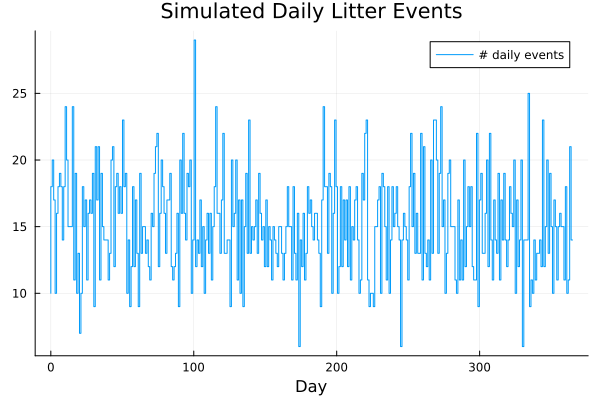

In [36]:
_rθ = range(0, _𝚂, length=1*_𝚂)
_p = plot(title="Simulated Daily Litter Events", xlabel="Day")
_p = plot!(_rθ, _yˢⁱᵐ, linetype=:steppre, label="# daily events", c=1)
plot(_p)

### Uncertainty Model

### Agent Model (Generative Model)

In this project, we are going to perform an exact inference for a litter model that can be represented as:

$$\begin{aligned}
p(\theta) &= \mathrm{\Gamma}(\theta \mid \alpha^{\Gamma}, \theta^{\Gamma}),\\
p(x_i \mid \theta) &= \mathrm{Pois}(x_i \mid \theta),\\
\end{aligned}$$

where $x_i \in \{0, 1, ...\}$ is an observation induced by a Poisson likelihood while $p(\theta)$ is a Gamma prior distribution on the parameter of the Poisson distribution.
We are interested in inferring the posterior distribution of $\theta$.

The generative model is:

$$
\begin{aligned}
p(x_:,\theta)    &= p(x_: \mid \theta) \cdot p(\theta) \\
                 &= p(x_{1:N} \mid \theta) \cdot p(\theta) \\
                 &= \prod_{i=1}^N{p(x_i \mid \theta)} \cdot p(\theta) \\
                 &= \prod_{i=1}^N{\mathrm{Pois}(x_i \mid \theta)} \cdot \Gamma(\theta \mid \alpha^{\Gamma}, \theta^{\Gamma})
\end{aligned}
$$

#### Implementation of the Agent Model (Generative Model)

We will use the RxInfer Julia package. RxInfer stands at the forefront of Bayesian inference tools within the Julia ecosystem, offering a powerful and versatile platform for probabilistic modeling and analysis. Built upon the robust foundation of the Julia programming language, RxInfer provides researchers, data scientists, and practitioners with a streamlined workflow for conducting Bayesian inference tasks with unprecedented speed and efficiency.

At its core, RxInfer leverages cutting-edge techniques from the realm of reactive programming to enable dynamic and interactive model specification and estimation. This unique approach empowers users to define complex probabilistic models with ease, seamlessly integrating prior knowledge, data, and domain expertise into the modeling process.

With RxInfer, conducting Bayesian inference tasks becomes a seamless and intuitive experience. The package offers a rich set of tools for performing parameter estimation, model comparison, and uncertainty quantification, all while leveraging the high-performance capabilities of Julia to deliver results in a fraction of the time required by traditional methods.

Whether tackling problems in machine learning, statistics, finance, or any other field where uncertainty reigns supreme, RxInfer equips users with the tools they need to extract meaningful insights from their data and make informed decisions with confidence.

RxInfer represents a paradigm shift in the world of Bayesian inference, combining the expressive power of Julia with the flexibility of reactive programming to deliver a state-of-the-art toolkit for probabilistic modeling and analysis. With its focus on speed, simplicity, and scalability, RxInfer is poised to become an indispensable tool for researchers and practitioners seeking to harness the power of Bayesian methods in their work.


To transfer the above factorized generative model to the RxInfer package, we need to include each of the factors:

- $N$ Kronecker-$\delta$ factors (for the N observations)
- $1$ Gamma factor (for the prior distribution)
- $N$ Poisson factors (for the litter events)

In [37]:
## parameters for the prior distribution
_αᴳᵃᵐ, _θᴳᵃᵐ = 350., .05;

In [38]:
## Litter model: Gamma-Poisson
@model function litter_model(x, αᴳᵃᵐ, θᴳᵃᵐ)
    ## prior on θ parameter of the model
    θ ~ Gamma(shape=αᴳᵃᵐ, rate=θᴳᵃᵐ) ## 1 Gamma factor

    ## assume daily number of litter incidents is a Poisson distribution
    for i in eachindex(x)
        x[i] ~ Poisson(θ) ## not θ̃; N Poisson factors
    end
end

### Agent (Policy) Evaluation

#### Evaluate with simulated data

In [39]:
_result = infer(
    model= litter_model(αᴳᵃᵐ= _αᴳᵃᵐ, θᴳᵃᵐ= _θᴳᵃᵐ), 
    data= (x= _yˢⁱᵐ, )
)

Inference results:
  Posteriors       | available for (θ)


In [40]:
_θˢⁱᵐ = _result.posteriors[:θ]

GammaShapeRate{Float64}(a=5873.0, b=365.05)

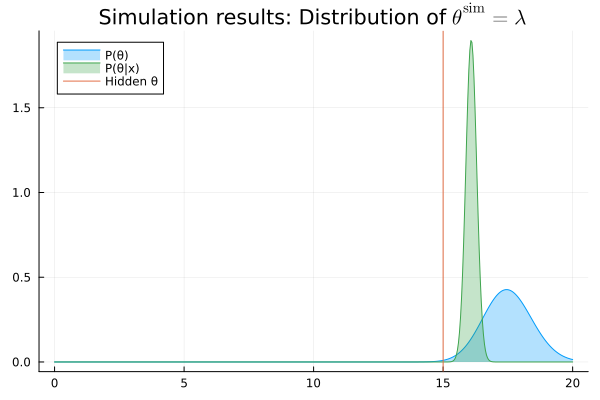

In [41]:
_rθ = range(0, 20, length=500)
_p = plot(title="Simulation results: Distribution of "*L"θ^{\mathrm{sim}}=λ")
plot!(_rθ, (x) -> pdf(Gamma(_αᴳᵃᵐ, _θᴳᵃᵐ), x), fillalpha=0.3, fillrange=0, label="P(θ)", c=1,)
plot!(_rθ, (x) -> pdf(_θˢⁱᵐ, x), fillalpha=0.3, fillrange=0, label="P(θ|x)", c=3)
vline!([_θ̆ˢⁱᵐ], label="Hidden θ", c=2)

### Evaluation

The following data comes from the inspections of the volunteers over a period of 12 months:

In [42]:
_fld_df = DataFrame(XLSX.readtable("../data/litter_incidents.xlsx", "Sheet1"))
_yᶠˡᵈ = fld_data(_fld_df, _𝚂, _𝙳, _𝙼, _𝚅, _𝙲) ## field data
_yᶠˡᵈ = first.(first.(first.(first.(_yᶠˡᵈ))))
print(IOContext(stdout, :displaysize => (24, 30)), _yᶠˡᵈ[1:10]);

[5.0, 7.0, 6.0, 10.0, 8.0, 5.0, 7.0, 9.0, 13.0, 9.0]

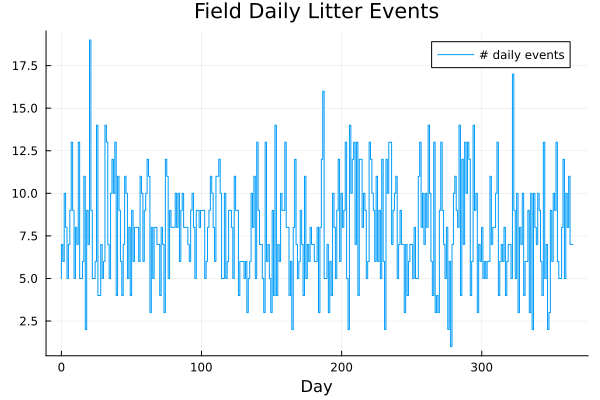

In [43]:
_rθ = range(0, _𝚂, length=1*_𝚂)
_p = plot(title="Field Daily Litter Events", xlabel="Day")
_p = plot!(_rθ, _yᶠˡᵈ, linetype=:steppre, label="# daily events", c=1)
plot(_p)

In [44]:
_result = infer(
    model=litter_model(αᴳᵃᵐ= _αᴳᵃᵐ, θᴳᵃᵐ= _θᴳᵃᵐ), 
    data= (x= _yᶠˡᵈ, )
)

Inference results:
  Posteriors       | available for (θ)


In [45]:
_θᶠˡᵈ = _result.posteriors[:θ]

GammaShapeRate{Float64}(a=3200.0, b=365.05)

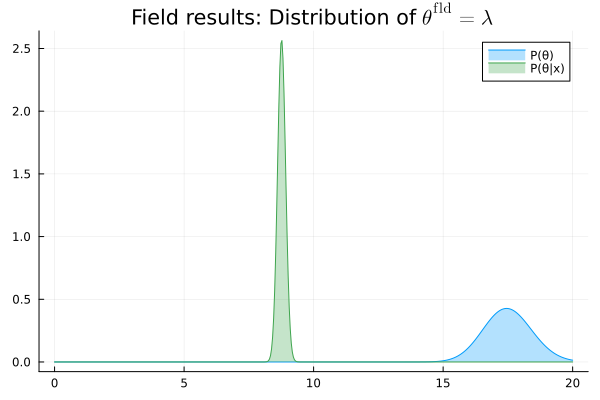

In [46]:
_rθ = range(0, 20, length=500)
_p = plot(title="Field results: Distribution of "*L"θ^{\mathrm{fld}}=λ")
plot!(_rθ, (x) -> pdf(Gamma(_αᴳᵃᵐ, _θᴳᵃᵐ), x), fillalpha=0.3, fillrange=0, label="P(θ)", c=1,)
plot!(_rθ, (x) -> pdf(_θᶠˡᵈ, x), fillalpha=0.3, fillrange=0, label="P(θ|x)", c=3)

The actual generative process actually had a much lower mean daily litter events, around about 8 events per day. The client can work with this value during planning of how to use his volunteers in the field.